Ablation

1. Activation function ( tanh[95.34%],
                        relu[95.32%],
                        **elu[95.42%],**
                        softsign[95.05%],
                        softplus[77.64%])

2. Pooling layers ( ** Max[95.48%], **
                  Average[88.16%])

3. Learning rate( 0.01[84.06%], 
                0.006[89.3%],
                **0.001[95.48%],** 
                0.0008[95.19%])

4. Optimizer ( **Adam[95.48%]**, 
              Nadam [95.38%], 
              SGD [86.18%], 
              Adamax [94.17%], 
              RMSprop [95.04%])

5. loss function ( Binary Crossentropy[95.23%], 
              **categorical crossentropy[95.48%]**, 
              Mean squared error[95.39%], 
              mean absolute error[92.31%], 
              mean squared logarithmic error[15.32%])









In [1]:
!nvidia-smi

Thu Sep  8 08:47:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -u "/content/drive/MyDrive/OCT Project/OCT Code & Dataset/Image Processing/Alpha Beta on Median Erosion/CNVA.zip" -d "/content/OCT_DATA"

print('\ndone!')

Streaming output truncated to the last 5000 lines.
  inflating: /content/OCT_DATA/CNVA/CNV_Al 5012.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4989.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4979.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4993.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 5007.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4984.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4986.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4999.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 5005.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 5013.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4997.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4974.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4978.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4990.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4980.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 4983.jpeg  
  inflating: /content/OCT_DATA/CNVA/CNV_Al 5002.jpeg  
  inflating: /

In [7]:
import os

# folder path
dir_path ='/content/OCT_DATA/NORMALA'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 51390


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os
import numpy as np

In [9]:
labels = ["CNVA", "DMEA", "DRUSENA","NORMALA"]
img_size = 32
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = get_data("/content/OCT_DATA")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


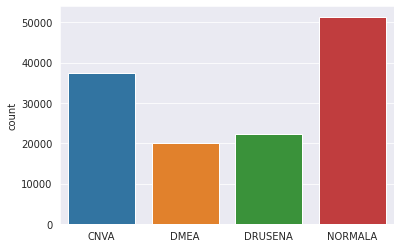

In [11]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("CNVA")
    elif(i[1] == 1):
          l.append("DMEA")
    elif(i[1] == 2):
          l.append("DRUSENA")
    elif(i[1] == 3):
          l.append("NORMALA")

            
       
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'CNVA')

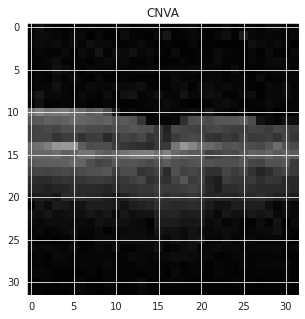

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [13]:
x_train = []
y_train = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

In [14]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x_train, y_train,
    test_size=0.15, stratify=y_train, random_state=42)

In [15]:
!pip install -U -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 34.1 MB/s 


In [27]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

In [17]:
y_train = keras.utils.to_categorical(
    y_train, num_classes=4, dtype='float32'
)
y_test = keras.utils.to_categorical(
    y_test, num_classes=4, dtype='float32'
)

In [45]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 1
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 32

In [46]:
num_classes = 4
input_shape = (32, 32, 3)

In [47]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (111475, 32, 32, 3) - y_train shape: (111475, 4)
x_test shape: (19673, 32, 32, 3) - y_test shape: (19673, 4)


In [48]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation='elu',
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [49]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [50]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [51]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

In [52]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    model.summary()
    return model

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 32, 32, 3)   0           ['input_13[0][0]']               
                                                                                                  
 cct_tokenizer_12 (CCTTokenizer  (None, 64, 128)     75456       ['data_augmentation[4][0]']      
 )                                                                                                
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 64, 128)     0           ['cct_tokenizer_12[0][0]']

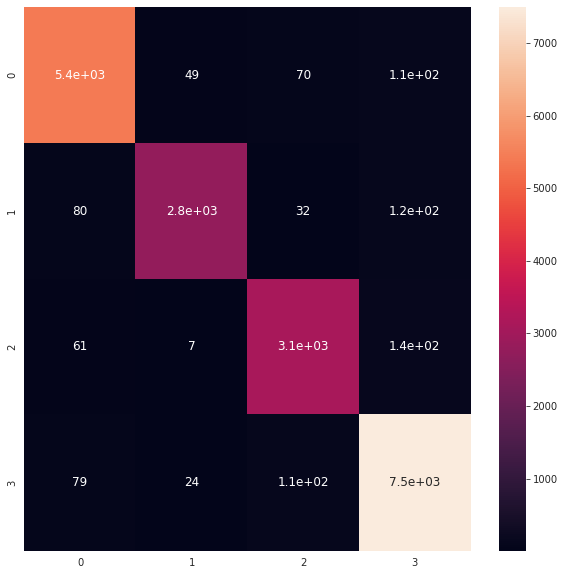

In [57]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/CCT_final_h5/model.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.15,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    from sklearn.metrics import classification_report, confusion_matrix



    # as I've trained my model on MNIST as odd or even (binary classes)
    target_names = ["CNVA", "DMEA", "DRUSENA","NORMALA"]


    # get predict prob and label 
    ypred = model.predict(x_test, verbose=1)
    ypred = np.argmax(ypred, axis=1)
    print(classification_report(np.argmax(y_test, axis=1), ypred, target_names=target_names))
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd 

    cm = confusion_matrix(np.argmax(y_test, axis=1), ypred)
    cm = pd.DataFrame(cm, range(4),range(4))
    plt.figure(figsize = (10,10))

    sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
    plt.show()
    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)